# Demo of Use Cases of GenCAT

We demonstrate three use cases: 
1. Accuracy (node classification) & various class preference means.
  + We evaluate accuracy (node classification task) of graph analysis methods by using graphs with various class preference means. 
  + This demo shows GenCAT clarifies whether graph analysis methods can capture various connection proportions between classes, such as the heterophily property. 
2. Accuracy (node classification) & various attribute-class correlation.
  + We evaluate accuracy of graph analysis methods by using graphs with various attribute-class correlations. 
  This demo shows GenCAT clarifies whether graph analysis methods perform well with random attributes. 
3. Training time & various graph sizes
  + We evaluate scalability of graph analysis methods by using graphs with various sizes, which GenCAT generates. 

In all experiments, we generate three graphs with the same setting and run graph analysis methods with three restarts for each generated graph. 
Totally, we obtain nine runs for each setting and report the average and standard deviation of them. 

In [1]:
!pip install powerlaw
!pip install jgraph
!pip install tensorflow-gpu==1.15.5

     |████████████████████████████████| 119 kB 14.6 MB/s 


In [2]:
import matplotlib.pyplot as plt
import sympy
import seaborn as sns
import numpy as np
import pandas as pd

data = "GenCAT_cora"
drive_root = "/content/drive/My Drive/Colab Notebooks/GenCAT/"
drive_root_command = "/content/drive/MyDrive/Colab\ Notebooks/GenCAT/"
data_path = drive_root_command + "datasets/"

method_dic = dict()
method_dic["GCN"] = drive_root_command + "gcn-master/gcn/train.py"
method_dic["GAT"] = drive_root_command + "GAT-master/train_gat.py"
method_dic["H2GCN"] = drive_root_command + "H2GCN-master/h2gcn/run_experiments.py"
%config InlineBackend.figure_formats = {'png', 'retina'}
methods = ["GCN", "GATsp", "H2GCN"]

import sys
import os.path
sys.path.append(os.path.join(drive_root))
import numpy as np
import time
import pandas as pd

import gencat
from func import cpm_cpd_plot, att_plot, loadData, _load_data, save_graph, compute_graph_statistics, feature_extraction

# loading files describing the results and draw picture by Seaborn

In [22]:
def result_load(tag, methods, alpha_l, trials=3, n_graphs=3):
  acc_dic = dict();time_dic = dict();perEpoch_dic = dict();stop_dic=dict()

  for i, method in enumerate(methods):
    acc_dic[method] = dict()
    acc_dic[method]["ave"] = []
    acc_dic[method]["dev"] = []
    time_dic[method] = dict()
    time_dic[method]["ave"] = []
    time_dic[method]["dev"] = []
    perEpoch_dic[method] = dict()
    perEpoch_dic[method]["ave"] = []
    perEpoch_dic[method]["dev"] = []
    stop_dic[method] = dict()
    stop_dic[method]["ave"] = []
    stop_dic[method]["dev"] = []
    for alpha in alpha_l:
      tag_ = method+ "_" + data+tag + str(alpha) + "_"
      tmp_acc = []
      tmp_time = []
      tmp_perEpoch = []
      tmp_stop = []
      for graphIter in range(n_graphs):
        tag_1 = tag_ + str(graphIter) + "_"
        for runIter in range(trials):
          tag_2 = tag_1 + "iter" + str(runIter)
          with open(drive_root+"experimental_results/"+tag_2, 'r') as f:
            tmp_acc.append(float(f.readline().replace("\n","")))
            tmp_time.append(float(f.readline().replace("\n","")[:-5]))
            try:
              tmp_perEpoch.append(float(f.readline().replace("\n","")))
              tmp_stop.append(int(f.readline().replace("\n","")))
            except Exception:
              tmp_perEpoch.append(0)
              tmp_stop.append(0)
      acc_dic[method]["ave"].append(np.average(tmp_acc))
      acc_dic[method]["dev"].append(np.std(tmp_acc))
      time_dic[method]["ave"].append(np.average(tmp_time))
      time_dic[method]["dev"].append(np.std(tmp_time))
      perEpoch_dic[method]["ave"].append(np.average(tmp_perEpoch))
      perEpoch_dic[method]["dev"].append(np.std(tmp_perEpoch))
      stop_dic[method]["ave"].append(np.average(tmp_stop))
      stop_dic[method]["dev"].append(np.std(tmp_stop))
  return acc_dic, time_dic, perEpoch_dic, stop_dic

def draw_pic(methods, result_dic, tag, x=[], ylim=None, xticksRotation=0, xlabel='', ylabel=''):
  plt.rcParams['text.usetex'] = True
  plt.style.use('default')
  sns.set()
  sns.set_style('whitegrid')
  sns.set_palette('Set1')
  ncol=1

  if tag == "_cpm_variants_":
    xlabel="Average of the diagonal elements of $M$\n(heterophily) <<<---------------------------->>> (homophily)"
    ylabel='Accuracy (node classfication)'
    x = [0.03,0.11,0.21,0.31,0.41,0.51,0.61,0.71,0.81]
  elif tag == "_att_variants_":
        # "Accuracy with various attribute-class correlations", # title
    xlabel='[1 : $\u03b2$]\nRatio for mixing attribute values with the average\n(random) <<<----------------------->>> (similar to original)'
    # xlabel='Ratio for mixing attribute values with the average\n(random) <<<----------------------->>> (similar to original)\n[original attribute : the average]'
    ylabel='Accuracy (node classfication)'
    x=[]
    b_list =[256,128,64,32,16,8,4,2,1,0]
    # b_list =[-1,256,128,64,32,16,8,4,2,1,0]
    for b in b_list:
      if b != -1:
        x.append("1:"+str(b))
      else:
        x.append("random")
  elif tag == "_fixed_nodes_":
    xlabel='The number of edges' # 'The number of nodes is fixed with 2708 which is the same to Cora.',
    if ylabel == '':
      ylabel='Training time per epoch [sec]'
    else:
      ncol=3
    x =[5000,10000, 15000, 20000, 25000, 30000]
  elif tag == "_graph_size_":
    xlabel = "How many times larger than\n the number of nodes in Cora." # \nThe number of edges scales linearly to the number of nodes.'
    if ylabel == '':
      ylabel = 'Training time [sec]'
    x=[1,2,3,4,5,6]


  fig = plt.figure(figsize=(5,3))
  ax = fig.add_subplot(1, 1, 1)
  markers = ['o', 'v', 'x', 'D','^',"-","*"]
  # markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3"]

  for i,method in enumerate(methods):
    y1 = result_dic[method]["ave"]
    e1 = result_dic[method]["dev"]
    if method == "GATsp":
      method = "GAT"
    ax.errorbar(x, y1, yerr=e1, marker=markers[i], label=method, capthick=1, capsize=8, lw=1)

  if ylim != None:
    ax.set_ylim(ylim[0], ylim[1])
  # ax.set_title(title)
  ax.set_xlabel(xlabel,size=11)
  ax.set_ylabel(ylabel)

  ax.legend(ncol=ncol)
  plt.xticks(rotation=xticksRotation)
  plt.show()

In [4]:
import copy
def config_diagonal(M,D,x=1):
  k = M.shape[0] # number of classes
  M_ = copy.deepcopy(M)
  D_ = copy.deepcopy(D)
  if x != 0:
    for i in range(k): # for each diagonal element
  # for i in range(int(k/2)+1,k):
      for j in range(k):
        if i == j:
          M_[i][j] -= 0.1 * x
        else:
          M_[i][j] += (0.1 * x) / (k-1)
      M_[M_<0] = 0
    for i in range(k):
    # for i in range(int(k/2)+1,k):
      for j in range(k):
        if i == j:
          D_[i][j] = D_[i][j] * (M_[i][j]/(M_[i][j]+0.1*x))
        else:
          D_[i][j] = D_[i][j] * (M_[i][j]/(M_[i][j]- (0.1)/(k-1)))
    for i in range(k):
      M_[i] = M_[i] / sum(M_[i])    
    D_[D_<=0] = 0
  return M_, D_

def mix_random(H,beta):
  H_ = copy.deepcopy(H)
  if beta != -1:
    H_ = (H_ + beta*np.average(H)) / (beta+1)
  else: # complete random
    print("random!")
    H_ = np.zeros(H.shape) + np.average(H)
  return H_

def print_statistics(adj, features, labels, data=""):
  if data == "load":
    print("\n\n#############################")
    print("#########   loaded data   #########")
    print("#############################")
  elif data == "generated":
    print("\n\n#############################")
    print("######### generated data ########")
    print("#############################")
  print("The number of nodes: " + str(adj.shape[0]))
  print("The number of edges: " + str(int(adj.sum()/2)))
  print("The number of attributes: " + str(features.shape[1]))
  M, D, class_size, H, node_degree = feature_extraction(adj,features,labels)
  plt.rcParams["figure.figsize"] = (2.5, 2.5)
  plt.rcParams["font.size"] = 8
  plt.title("Class preference mean", fontsize=13)
  hm = sns.heatmap(M,annot=True, cmap='hot_r', fmt="1.2f", cbar=False, square=True)
  plt.xlabel("class",size=15)
  plt.ylabel("class",size=15)
  # plt.tight_layout()
  plt.show()

## Demonstrate how useful graphs generated by GenCAT are to evaluate graph analysis methods.



---

#The first demo for showing the use case of GenCAT

## GenCAT can generate graphs with various class preference means, which are used to evaluate graph analysis methods. 

Let $k$ be the number of classes and $M\in R^{k\times k}$ be a class preference mean of an input graph.

To generate graphs with various properties in terms of class preference mean, I change diagonal elements $M'[l][l] = M[l][l]-0.1*a$, where $a$ is an input parameter. 

######
## Graph Generation Part (see "demo_GenCAT_cpm.ipynb" for detailed experimental parts)
######

The number of nodes: 2708
The number of edges: 5278
The number of attributes: 1433


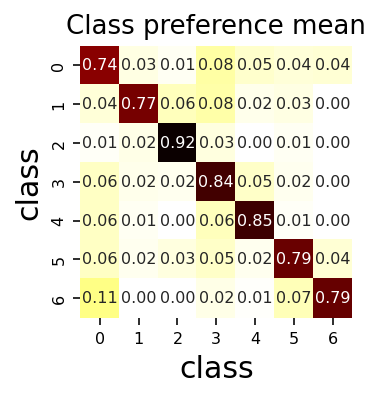

The number of nodes: 2708
The number of edges: 5269
The number of attributes: 1433


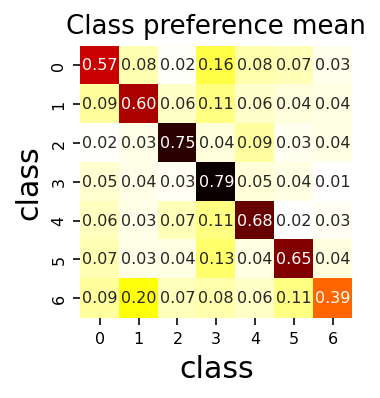

In [5]:
#### Parameter Setting Part ####
# parameter extraction
dataset_str = 'cora' # ['cora', 'citeseer', 'pubmed']
adj, features, labels = _load_data(dataset_str) # load dataset
M, D, class_size, H, node_degree = feature_extraction(adj,features,labels)
print_statistics(adj, features, labels)
x_list = [8,7,6,5,4,3,2,1,0]
tag = "_cpm_variants_" # tag for identifying demo

# configuration
x = 1 # for example, we show the case of x=8
M_config, D_config = config_diagonal(M, D, x) # M_config[l,l] = M[l,l] - 0.1*x

#### Graph Generation Part ####
S,X,Label = gencat.gencat(M_config,D_config,H,class_size=class_size,theta=node_degree)
# save the generated graph
save_graph(S,X,Label,dataset_str="GenCAT_"+dataset_str+tag+str(x))
print_statistics(S,X,Label)

In [24]:
tag = "_cpm_variants_" # tag for identifying demo
alpha_list = [8,7,6,5,4,3,2,1,0]

In [10]:
tag = "_cpm_variants_" # tag for identifying demo
#### Parameter Setting Phase ####
# parameter extraction
dataset_str = 'cora' # ['cora', 'citeseer', 'pubmed']
adj, features, labels = _load_data(dataset_str) # load dataset
M, D, class_size, H, node_degree = feature_extraction(adj,features,labels)

alpha_list = [8,7,6,5,4,3,2,1,0]
for alpha in alpha_list: # variants of class preference means
  # configuration
  M_config, D_config = config_diagonal(M, D, alpha) # configuration
  #### Graph Generation Phase ####
  S,X,Label = gencat.gencat(M_config,D_config,H,
                            class_size=class_size,theta=node_degree)
  save_graph(S,X,Label,dataset_str="GenCAT_"+dataset_str+tag+str(alpha))

  #### Execution of Graph Analytic Methods Phase ####
  data_in = "GenCAT_"+dataset_str+tag+str(alpha)
  # specify the pass for the source code
  method = method_dic['GCN'] # ['GCN', 'GAT', 'H2GCN']
  # run graph analysis method
  !python $method --dataset $data_in 

1 Physical GPUs, 1 Logical GPUs
Early stopping...
elapsed_time:10.73810625076294[sec]
Optimization Finished!
Test set results: cost= 0.66765 accuracy= 0.89649 time= 0.00599


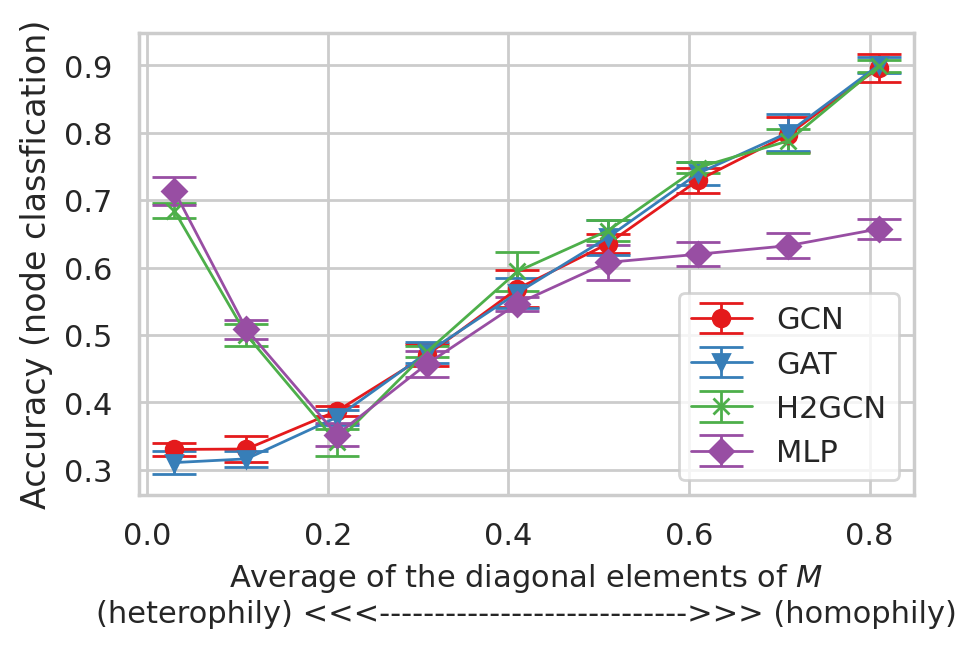

In [25]:
#### Result Viewer Part ####
# load results of graph analysis methods with generated graphs
acc_dic, time_dic, _, _ = result_load(tag,methods+["MLP"],alpha_list) 
# draw picture showing the results
draw_pic(methods+["MLP"],acc_dic,tag)

Note that Cora is a graph dataset with the strong homophily property. 
The most right point indicates the result of the graph generated from the class preference mean of Cora. 

The paper of H2GCN reports that its accuracy on Cora is $87.81\%$ that is similar to our result from the right most generated graph (only 5% error!).

## Observation

### homophily
All methods perform well with the dataset of strong homophily, which is similar to Cora dataset. 

### random
All methods do not perform with the dataset of "$a=-0.7$" that is almost random graphs. 
Note that in GenCAT node-class membership is shared by the topology and attributes so the dataset of "$a=-0.7$" has almost random attributes. 

### heterophily
Finally, we discuss the cases of the heterophily property, which are $a=-0.8, -0.9$.
H2GCN achieves higher results than others since it can capture the heterophily phenomenon. 
GCN and GAT do not utilize it since they assume that input graphs have the homophily property. 

The reason they obtain higher results than random ($a=-0.7$) is that 



---
# The second demo of the use case of GenCAT

## GenCAT can generate graphs with various attribute-class correlation, which are used to evaluate graph analysis methods. 

Let $d$ be the demension of attributes and $H\in \mathbb{R}^{d\times k}$ be an attribute-class correlation of an input data. 

To generate graphs with various properties in terms of attribute-class correlation, I mix the average of $H$ to it with a certain degree $b$. 

$H' = (H + b\sum H / (d*k))/(1+b).$ 

If $b=0$, $H'=H$. If $b$ is large, $H'$ is close to uniform, that is, $H'$ is less informative to predict node labels. 

######
## Graph Generation Part (see "demo_GenCAT_attributeTest.ipynb" for detailed experimental parts)
######

In [26]:
tag = "_att_variants_" # tag for identifying demo
beta_list =[256,128,64,32,16,8,4,2,1,0]

In [18]:
#### Parameter Setting Phase ####
# parameter extraction
dataset_str = 'cora' # ['cora', 'citeseer', 'pubmed']
adj, features, labels = _load_data(dataset_str) # load dataset
M, D, class_size, H, node_degree = feature_extraction(adj,features,labels)

for beta in beta_list: # variants of attribute-class correlation
  # configuration
  H_config = mix_random(H,beta) # configuration
  #### Graph Generation Phase ####
  S,X,Label = gencat.gencat(M,D,H_config,
                            class_size=class_size,theta=node_degree)
  save_graph(S,X,Label,dataset_str="GenCAT_"+dataset_str+tag+str(beta))

  #### Execution of Graph Analytic Methods Phase ####
  data_in = "GenCAT_"+dataset_str+tag+str(beta)
  # specify the pass for the source code
  method = method_dic['GCN'] # ['GCN', 'GAT', 'H2GCN']
  # run graph analysis method
  !python $method --dataset $data_in

1 Physical GPUs, 1 Logical GPUs
Early stopping...
elapsed_time:13.453329086303711[sec]
Optimization Finished!
Test set results: cost= 0.95970 accuracy= 0.80037 time= 0.00457


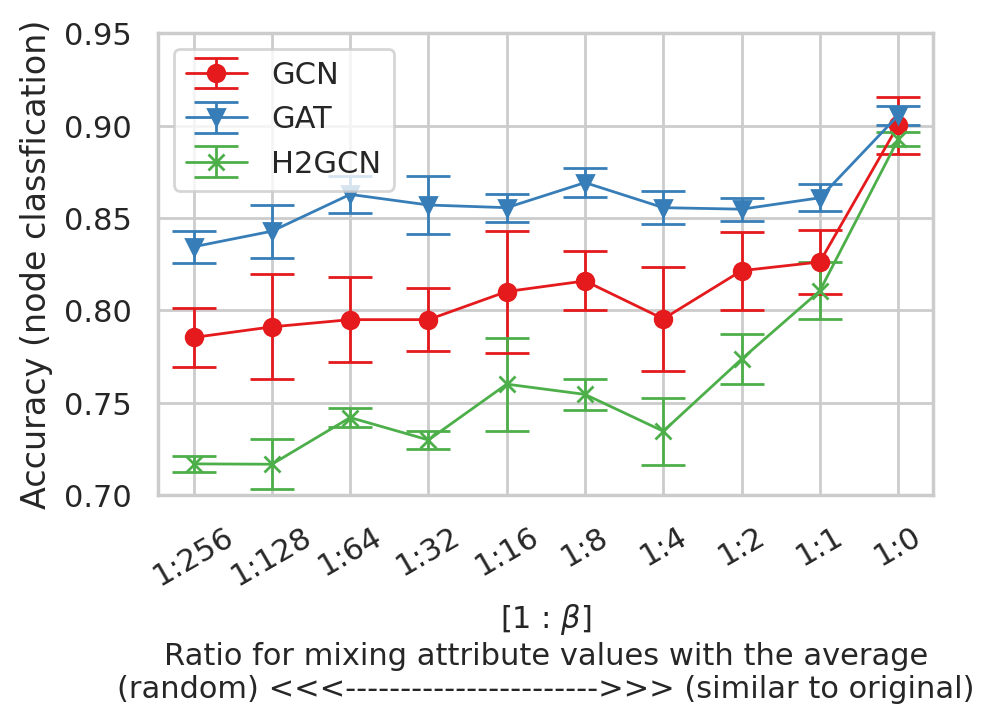

In [27]:
#### Result Viewer Part ####
# load results of graph analysis methods with generated graphs
acc_dic, time_dic, _, _ = result_load(tag, methods, beta_list) 
# draw picture showing the results
draw_pic(methods, acc_dic, tag, ylim=[0.70, 0.95], xticksRotation=30)

## Observation

The most right point indicates the graph generated by using $H$ extracted from Cora. 

Even if $H'$ is uniform, graph analysis methods achieve over $80\%$ since Cora has the strong homophily property. 



---

#The third demo for showing the use case of GenCAT

---

##Training time for various numbers of edges and fixed numbers of nodes

### We can see how graph analysis methods scale to the number of edges. 


We extract class preference mean/deviation and attribute-class correlation from Cora. 

Then, we use them as inputs of GenCAT. 

GCN, GAT, and H2GCN have an early stop functionality so they stop when their losses do not decrease over sevaral epochs. 

######
## Graph Generation Part (see "demo_GenCAT_fixed_node.ipynb" for detailed experimental parts)
######

In [ ]:
tag = "_fixed_nodes_" # tag for identifying demo
#### Parameter Setting Phase ####
# parameter extraction
dataset_str = 'cora' # ['cora', 'citeseer', 'pubmed']
adj, features, labels = _load_data(dataset_str) # load dataset
M, D, class_size, H, node_degree = feature_extraction(adj,features,labels)

gamma_list =[5000,10000,15000,20000,25000,30000]
for gamma in gamma_list: # variants of attribute-class correlation
  # configuration
  num_node = len(node_degree)
  #### Graph Generation Phase ####
  S,X,Label = gencat.gencat(M,D,H,class_size=class_size,
                            n=num_node,m=gamma)
  save_graph(S,X,Label,
             dataset_str="GenCAT_"+dataset_str+tag+str(gamma))

  #### Execution of Graph Analytic Methods Phase ####
  data_in = "GenCAT_"+dataset_str+tag+str(gamma)
  # specify the pass for the source code
  method = method_dic['GCN'] # ['GCN', 'GAT', 'H2GCN']
  # run graph analysis method
  !python $method --dataset $data_in 

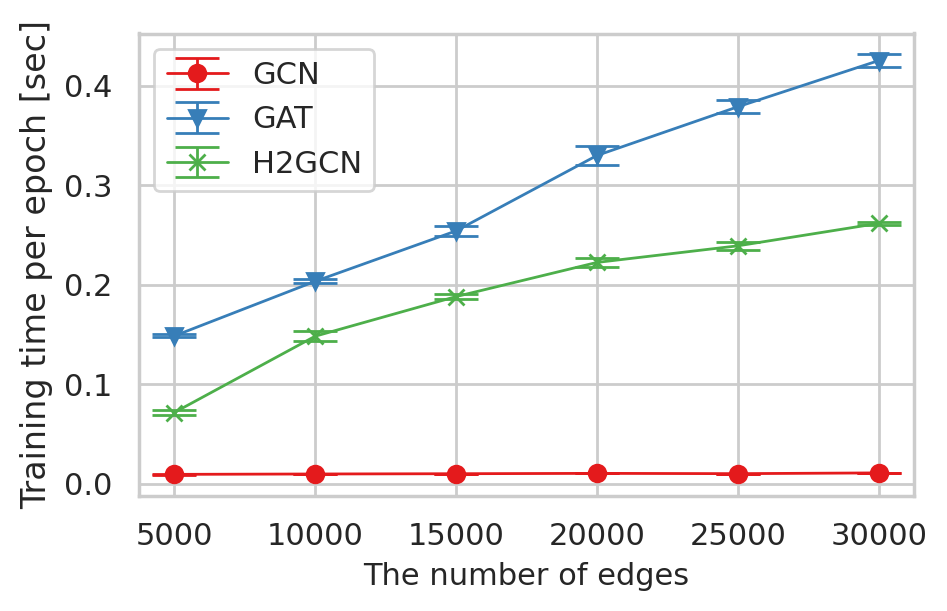

In [ ]:
#### Result Viewer Part ####
# load results of graph analysis methods with generated graphs
acc_dic,time_dic,perEpoch,stop=result_load(tag, methods,gamma_list) 
# draw picture showing the results
draw_pic(methods,perEpoch,tag)


## Various Graph Sizes

### How does the number of nodes affect training time of graph analysis methods? 

We extract class preference mean/deviation and attribute-class correlation from Cora. 

Then, we use them as inputs of GenCAT. 

(Only one run has done.)

In [ ]:
tag = "_graph_size_"
methods = ["GCN", "GATsp", "H2GCN"]
gamma_list =[1,2,3,4,5,6]
acc_dic,time_dic,perEpoch,stop=result_load(tag,methods,gamma_list)

In [ ]:
tag = "_graph_size_" # tag for identifying demo
#### Parameter Setting Phase ####
# parameter extraction
dataset_str = 'cora' # ['cora', 'citeseer', 'pubmed']
adj, features, labels = _load_data(dataset_str) # load dataset
M, D, class_size, H, node_degree = feature_extraction(adj,features,labels)

gamma_list =[1,2,3,4,5,6]
for gamma in gamma_list: # variants of attribute-class correlation
  # configuration
  num_node = len(node_degree) * gamma
  num_edge = int(sum(node_degree)/2) * gamma
  #### Graph Generation Phase ####
  S,X,Label = gencat.gencat(M,D,H,class_size=class_size,
                            n=num_node,m=num_edge)
  save_graph(S,X,Label,
             dataset_str="GenCAT_"+dataset_str+tag+str(scale))

  #### Execution of Graph Analytic Methods Phase ####
  data_in = "GenCAT_"+dataset_str+tag+str(scale)
  # specify the pass for the source code
  method = method_dic['GCN'] # ['GCN', 'GAT', 'H2GCN']
  # run graph analysis method
  !python $method --dataset $data_in 

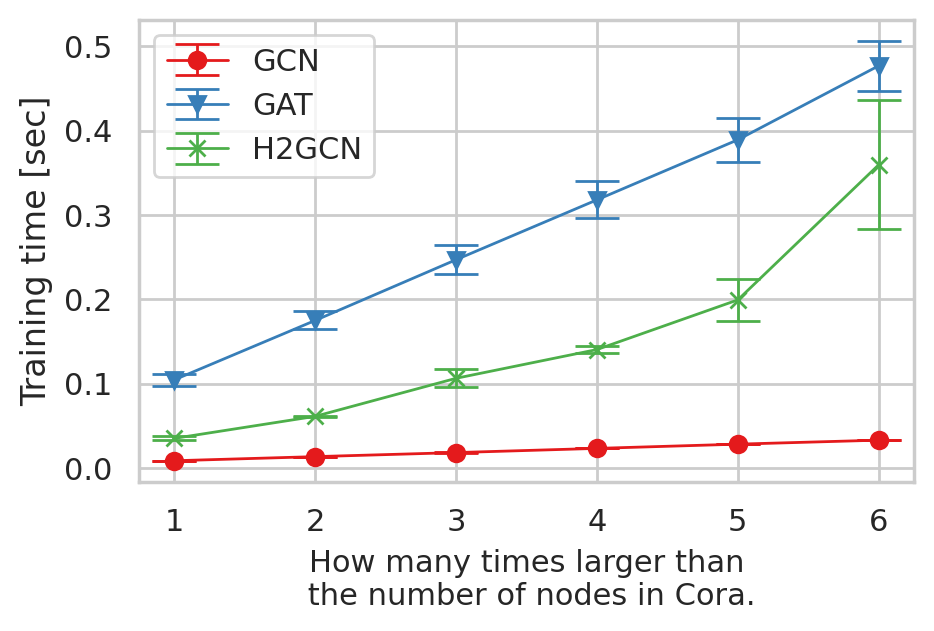

In [ ]:
#### Result Viewer Part ####
# load results of graph analysis methods with generated graphs
acc_dic,time_dic,perEpoch,stop=result_load(tag,methods,gamma_list) 
# draw picture showing the results
draw_pic(methods,perEpoch,tag)